In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, normalized_mutual_info_score, 
    precision_recall_curve, auc, roc_curve, 
    accuracy_score, log_loss, f1_score
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from collections import Counter, defaultdict
import scipy
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [2]:
BASE_DIR = './dataset/'
# train = pd.read_csv(f'{BASE_DIR}train_preprocessed.csv')
train = pd.read_csv(f'{BASE_DIR}train.csv')
train.fillna("", inplace=True)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
y_true = train['is_duplicate']
train.drop(['id','is_duplicate'], axis=1, inplace=True)
print(train.shape)

(404290, 4)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(train, y_true, stratify = y_true, test_size = 0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(283003, 4) (121287, 4) (283003,) (121287,)


In [5]:
# ## copied
# print("-"*10, "Distribution of output variable in train data", "-"*10)
# train_distr = Counter(y_train)
# train_len = len(y_train)
# print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
# print("-"*10, "Distribution of output variable in train data", "-"*10)
# test_distr = Counter(y_test)
# test_len = len(y_test)
# print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

In [6]:
## copied directly
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    """
    This function uses Seaborn Heatmap(s) to plot 3 different matrices. It plots the 
    Confusion Matrix, Precision Matrix and the Recall Matrix. The confusion matrix is as usual.
    In the Precision Matrix, the sum of the values in each column is 1. Similarly, in the
    Recall Matrix, the sum of the values in each row is 1.
    """
    
    C = confusion_matrix(test_y, predict_y)
    # Divide each element of the confusion matrix with the sum of elements in that column
    A = (((C.T)/(C.sum(axis=1))).T)
    # Divide each element of the confusion matrix with the sum of elements in that row
    B = (C/C.sum(axis=0))

    plt.figure(figsize=(12,10))
    
    labels = [0,1]
    cmap=sns.light_palette("blue")
    
    # Representing C in heatmap format
    plt.subplot(2, 2, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    # Representing B in heatmap format
    plt.subplot(2, 2, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    # Representing A in heatmap format
    plt.subplot(2, 2, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [7]:
# predicted_y = np.zeros((test_len, 2))
# for i in range(test_len):
#     rand_probs = np.random.rand(1,2)
#     predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])
# print("Log loss on Test Data using Random Model", log_loss(y_test, predicted_y, eps=1e-15))

# predicted_y = np.argmax(predicted_y, axis=1)
# plot_confusion_matrix(y_test, predicted_y)

## Logistic Regression

In [8]:
def logistic_regression(ngram = (1,1)):
    global train

    tfidf = TfidfVectorizer(analyzer='word', max_features=5000, token_pattern=r'\w{1,}', ngram_range=ngram)

    q1word_trans = tfidf.fit_transform(train['question1'].values)
    q2word_trans = tfidf.fit_transform(train['question2'].values)

    X = scipy.sparse.hstack((q1word_trans,q2word_trans))
    y = y_true
    
    X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

    clf = LogisticRegression(random_state=42, max_iter = 1000)
    clf.fit(X_train, y_train)
    predict_y = clf.predict_proba(X_test)
    print("Log loss:", log_loss(y_test, predict_y, labels = clf.classes_))

    predict_y = clf.predict(X_test)
    print("Confusion Matrix", confusion_matrix(y_test, predict_y))
    print("Accuracy : ",accuracy_score(y_test, predict_y)*100, "%")
    print("F1 score :", f1_score(y_test, predict_y)*100, "%")

    return clf


### Unigram

In [9]:
# predict_y = clf.predict(X_test)
# print("Confusion Matrix", confusion_matrix(y_test, predict_y))
# print("Accuracy : ",accuracy_score(y_test, predict_y)*100, "%")
# print("F1 score :", f1_score(y_test, predict_y)*100, "%")
clf = logistic_regression()
import pickle
pickle.dump(clf, open("./models/analysis3/lr_unigram_unprocessed.pkl", "wb"))

Log loss: 0.520801687372479
Confusion Matrix [[65809 10541]
 [20522 24415]]
Accuracy :  74.38884629020423 %
F1 score : 61.11924699285293 %


### Bigram

In [10]:
clf = logistic_regression((2,2))
import pickle
pickle.dump(clf, open("./models/analysis3/lr_bigram_unprocessed.pkl", "wb"))

Log loss: 0.5289804276529088
Confusion Matrix [[67278  9072]
 [22602 22335]]
Accuracy :  73.88508249029162 %
F1 score : 58.511474379126064 %


### Trigram

In [11]:
clf = logistic_regression((3,3))
import pickle
pickle.dump(clf, open("./models/analysis3/lr_trigram_unprocessed.pkl", "wb"))

Log loss: 0.5466758742345608
Confusion Matrix [[68977  7373]
 [25588 19349]]
Accuracy :  72.8239629968587 %
F1 score : 54.00298636598333 %


In [20]:
# Loading the Model
# sig_clf = pickle.load(open('./models/analysis3/logistic_regression.pkl', "rb"))

Best Alpha: 0.01, Train log loss: 0.5831339326495873
Best Alpha: 0.01, Test log loss: 0.5876469361328506
Total number of data points: 121305


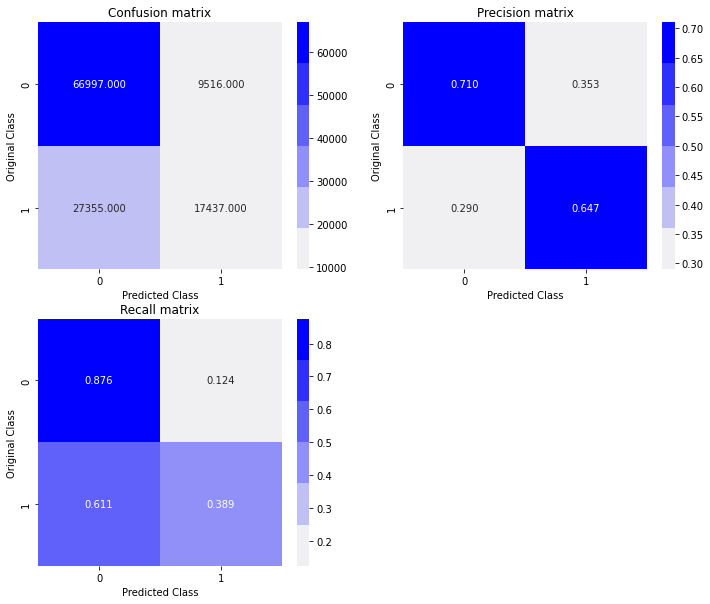

In [19]:
predict_y = clf.predict_proba(X_train)
print("Best Alpha: 0.01, Train log loss:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = clf.predict_proba(X_test)
print("Best Alpha: 0.01, Test log loss:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points:", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## SVM

In [9]:

def svm(ngram = (1,1), kernel = "linear"):
    global train

    tfidf = TfidfVectorizer(analyzer='word', max_features=100, token_pattern=r'\w{1,}', ngram_range=ngram)

    q1word_trans = tfidf.fit_transform(train['question1'].values)
    q2word_trans = tfidf.fit_transform(train['question2'].values)

    X = scipy.sparse.hstack((q1word_trans,q2word_trans))
    y = y_true
    
    X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

    clf = SVC(gamma='auto', kernel=kernel)
    clf.fit(X_train, y_train)
    # predict_y = clf.predict_proba(X_test)
    # print("Log loss:", log_loss(y_test, predict_y, labels = clf.classes_))

    predict_y = clf.predict(X_test)
    print("Confusion Matrix", confusion_matrix(y_test, predict_y))
    print("Accuracy : ",accuracy_score(y_test, predict_y)*100, "%")
    print("F1 score :", f1_score(y_test, predict_y)*100, "%")

    return clf


### Unigram

In [ ]:
clf = svm()
import pickle
pickle.dump(clf, open("./models/analysis3/svm_unigram_linear.pkl", "wb"))

In [ ]:
# predict_y = sig_clf.predict_proba(X_train)
# print("Best Alpha: 0.01, Train log loss:", log_loss(y_train, predict_y, labels=sig_clf.classes_))
# predict_y = sig_clf.predict_proba(X_test)
# print("Best Alpha: 0.01, Test log loss:", log_loss(y_test, predict_y, labels=sig_clf.classes_))
# predicted_y = np.argmax(predict_y, axis=1)
# print("Total number of data points:", len(predicted_y))
# plot_confusion_matrix(y_test, predicted_y)

### XGBoost

In [27]:
xgbr = xgb.XGBClassifier(verbosity = 1, n_estimators = 150, max_depth = 15, 
    objective = 'binary:logistic', eval_metric = 'logloss')
xgbr.fit(X_train, y_train)

d:\college\Sem_5\NLP\Project\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [28]:
# Saving the Model
pickle.dump(xgbr, open('./models/analysis3/xg_boost.pkl', 'wb'))

n_estimators: , max_depth: , Train log loss: 0.31752348074457937
n_estimators: , max_depth: , Test log loss: 0.4445936903539542
Total number of data points: 121287


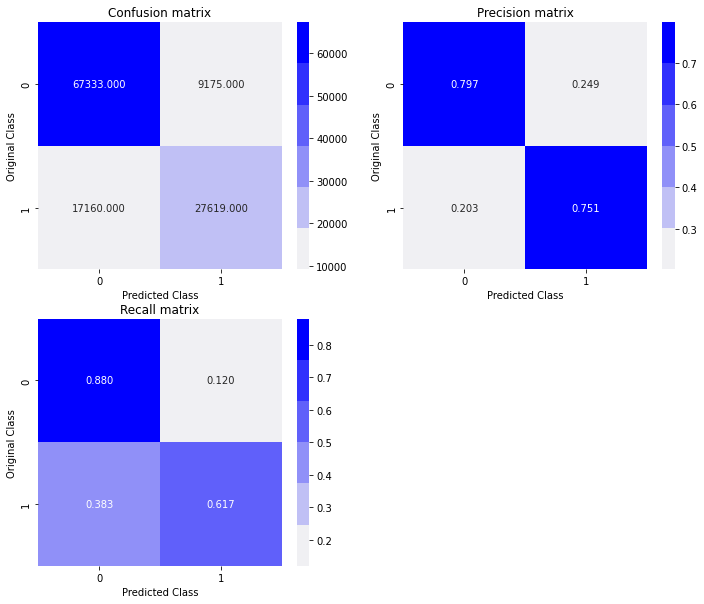

In [29]:
predict_y = xgbr.predict_proba(X_train)
print("n_estimators: , max_depth: , Train log loss:", log_loss(y_train, predict_y, labels=[0,1]))
predict_y = xgbr.predict_proba(X_test)
print("n_estimators: , max_depth: , Test log loss:", log_loss(y_test, predict_y, labels=[0,1]))
predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points:", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)